<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

# Análise Exploratória de Dados de Logística (Loggi)

# **Tópicos**

- Contexto;
- Pacotes e bibliotecas;
- Exploração de dados;
- Manipulação;
- Visualização;

---

## 1\. Contexto

Projeto de Dada Wraglinf com informações logísticas da Startup Loggi, com geração de DataFrames para melhor exploração de dados e extração de informações e geração de visualizações gráficas para ajudar na retirada de insights operacionais do Distrito Federal, considerando a correlação entre a posição dos hubs e suas regiões atendidas. Objetivando responder às principais questões:
- Questão 1: A distribuição de entregas por 'hub' está equilibrada?
- Questão 2: A localização dos hubs é favorável para eficiência das entregas?

## 2\. Pacotes e bibliotecas

In [38]:
import json

import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import geopy
import geopandas

from geopy.geocoders import Nominatim 
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

As informações de entregas logísticas da Loggi estão disponíveis no arquivo deliveries.json no link abaixo, logo, irei  extrair as informações e transformar em um DataFrame do pandas para manipular os dados.
**link:** https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json

3.1 Coleta de dados

In [39]:
#Coletando dado bruto .json
with open('deliveries.json', mode = 'r', encoding = 'utf8') as arquivo:
    data = json.load(arquivo)

#lendo com o pandas
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Podemos abservar que as colunas 'origin' e 'deliveries' possuem dados alinhados, irei agora ultilizar metodos como 'normalize' do pandas para separar esses dados, transformar em um novo DataFrame e juntas com o 'deliveries_df'.

3.2 Data Wrangling

In [40]:
#Criando um novo DataFrame a partir da coluna 'origin' usando json_normalize
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Novo DataFrame criado, vamos agora mescla com o 'deliveries_df' com metodo merge

In [41]:
deliveries_df = pd.merge(left= deliveries_df, right= hub_origin_df, how='inner', left_index= True, right_index= True)
#Excluindo a coluna 'origen', pra evitar redundancia
deliveries_df = deliveries_df.drop('origin', axis=1)
#selecionando as colunas novas e renomeando
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Vamos agora tirar os dados 'aninhados' da coluna 'deliveries', ultilizarei o metodo 'explode', esse metodo conserva o indice original e separa as informações em colunas.

In [42]:
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


Dados separados em linhas, porém conservando o índice, vamos agora criar um novo DataFrame a partir dessa estrutura. O objetivo final é ter um DataFrame organizado de forma mais adequada para análise e manipulação de dados.

In [43]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries': 'delivery_size'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['id'])).rename(columns={'deliveries': 'delivery_id'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries': 'delivery_lng'}),
  pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries': 'delivery_lat'}),
], axis= 1)

In [44]:
deliveries_normalized_df.head()

,delivery_size,delivery_id,delivery_lng,delivery_lat
0,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
0,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
0,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
0,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
0,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055


Vou agora mescla o DataFrame principal 'deliveries_df' com o novo DataFrame 'deliveries_normalized_df', na oportunidade vou tirar a coluna deliveries do DataFrame principal para evitar redundância de dados.

In [45]:
#Excluindo coluna 'deliveries'
deliveries_df = deliveries_df.drop('deliveries', axis= 1)
#mesclando os DataFrames
deliveries_df = pd.merge(left= deliveries_df, right= deliveries_normalized_df, how = 'right', left_index=True, right_index= True)
deliveries_df.reset_index(inplace= True, drop = True)

In [46]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_id,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055


3.3 Explorando os dados

Agora com os dados devidamente estruturados, irei fazer uma exploração desses dados com o intuído de identificar se a necessidade de lidar com dados ausentes, explora possíveis relações entre as variáveis, identificar padrões úteis para insights, etc.

In [47]:
deliveries_df.shape

(636149, 9)

In [48]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_id       636149 non-null  object 
 7   delivery_lng      636149 non-null  float64
 8   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


In [49]:
#procurando valores nulos
deliveries_df.isna().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_id         0
delivery_lng        0
delivery_lat        0
dtype: int64

In [50]:
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
vehicle_capacity         1
delivery_size           10
delivery_id         291566
delivery_lng        291566
delivery_lat        291566
dtype: int64

In [51]:
deliveries_df.describe()

,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
count,636149.000000,636149.000000,636149.0,636149.000000,636149.000000,636149.000000
mean,-47.949902,-15.802359,180.0,5.512111,-47.946087,-15.809492
std,0.091875,0.053463,0.0,2.874557,0.112769,0.082462
min,-48.054989,-15.838145,180.0,1.000000,-48.280779,-16.050028
25%,-48.054989,-15.838145,180.0,3.000000,-48.035911,-15.842795
50%,-47.893662,-15.805118,180.0,6.000000,-47.928967,-15.814033
75%,-47.893662,-15.805118,180.0,8.000000,-47.883394,-15.769516
max,-47.802665,-15.657014,180.0,10.000000,-47.310611,-15.500355


**Observação 1:** Percebesse que na coluna 'vehicle_capacity' os valores são sempre '180'. Já na coluna 'delivery_size' percebesse volumes variáveis, com média de 5.51 e desvio padrão de 2.87.

In [91]:
deliveries_df['region'].describe()

count     636149
unique         3
top         df-1
freq      304708
Name: region, dtype: object

**Observação 2:** Há 3 regiões, sendo a 'df-1' com o maior numero de entregas com 304.708 de um total de 636.149.

## 4\. Manipulação

4.1 Enriquecimento

Irei agora utilizar a geocodificação reversa, onde usarei as coordenadas disponíveis no DataFrame que criamos para transformar as coordenadas geográficas de um local em suas respectivas descrições textuais. Esse processo vai nos permitir analisar a correlação entre a localização de nossos HUBS e seus 'deliveries'.

In [53]:
#criando um novo DataFrame com a localização de nossos HUBS
hub_df = deliveries_df[['region','hub_lng','hub_lat']]
#removendo duplicatas, so queremos saber onde fica o hub.
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop = True)
hub_df

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Usaremos o modulo 'Nominatim' da biblioteca 'geopy' para realizar uma operação de geocodificação reversa.

In [54]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 13551965,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [55]:
#criando um limitação de taxa para evitar atingir limites de serviço
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

Usaremos a geocodificação nas coordenadas dos nossos 3 Hubs e extrair informações de bairros,cidades, etc.

In [56]:
hub_df['coordinates'] = hub_df['hub_lat'].astype(str)  + ', ' + hub_df['hub_lng'].astype(str) 
#criando colunas com a cordenadas e geodata dos hubs
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Podemos observar que as colunas 'coordinates' e 'geodata' possuem dados alinhados, assim como fiz no Data Frame 'deliveries_df' irei ultilizar o método 'normalize' do pandas para separar esses dados, transformando em um novo DataFrame e junta com o 'deliveries_df'.

In [57]:
hub_geodata_df =  pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,13551965,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,13548034,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,10766946,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [58]:
#renomeando as colunas 
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
#preenchendo dados ausentes
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
#removendo coluna hub_town
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Agora iremos enriquecer o Dataframe principal 'deliveries_df' com o endereço dos hubs

In [59]:
#Mescla os DataFrames hub_df e hub_geodata_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [60]:
#Mescla os DataFrames hub_df e deliveries_df
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_id','delivery_size', 'delivery_lng', 'delivery_lat']]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055


Agora temos o DataFrame principal 'deliveries_de' enriquecido com informações mais detalhadas da localização dos hubs, agora irei adicionar também o endereço das entregas. Vimos que o **hub** contém apenas 3 geolacalizações distintas, enquanto temos um total de **636.149** entregas, para maior enriquecimento de nossos dados eu vou baixar o arquivo 'deliveries-geodata.csv' disponibilizado pela **Loggi** no link: https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv

In [61]:
#lendo o arquivo 'deliveries-geodata.csv' e transformando em um DataFrame
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [62]:
#Mesclando os DataFrames 'deliveries-geodata.csv' e 'deliveries_df'
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Agora temos um DataFrame completo. com informações separadas de todas as entregas e seus respectivos hubs.

4.2 Controle de qualidade

In [63]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_id       636149 non-null  object 
 8   delivery_size     636149 non-null  int64  
 9   delivery_lng      636149 non-null  float64
 10  delivery_lat      636149 non-null  float64
 11  delivery_city     634447 non-null  object 
 12  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 63.1+ MB


In [64]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_id         False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [65]:
#Valor porcentual de todas as entregas
prop_df = deliveries_df[['delivery_city']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head()

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Name: count, dtype: float64

**Observação 3:** Podemos perceber que Brasília tem a maior participação percentual no total de entregas.

## 5\. Visualização

Para melhor visualização, irei ultilizar o pacote Python GeopPandas para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal.

- Mapa do Distrito Federal

Para criação do mapa do Distrito Federal vamos fazer o download dos dado no site do IBGE para criar o DataFrame mapa, link: https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip

Usaremos o arquivo 'distrito-federal.shp' e o 'distrito-federal.shx'

In [74]:
#Criando o mapa do distrito federal
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


- Mapa dos Hubs

In [67]:
#Novo DataFrame com apenas as colunas selicionadas sem linhas duplicadas
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
#Novo DataFrame com uma coluna nova 'geometry' que representa os pontos no espaço com base nas coordenadas
geo_hub_df = geopandas.GeoDataFrame(hub_df,geometry=geopandas.points_from_xy(hub_df['hub_lng'],hub_df['hub_lat']))
geo_hub_df


,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


- Mapa das entregas

Faremos o mesmo processo que foi feito no mapa dos hubs, adicionando uma coluna 'geometry' com o ponto no espaço que representa cada uma das entregas

In [75]:
#Novo DataFrame com uma coluna nova 'geometry' das entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Agora que temos as localizações exatas de cada entrega e seus respectivos hubs, iremos contruir um mapa para melhor visualização e criação de insights.

- Visualização

C:\Users\Gabriel Canuto\AppData\Local\Temp\ipykernel_11964\321756448.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


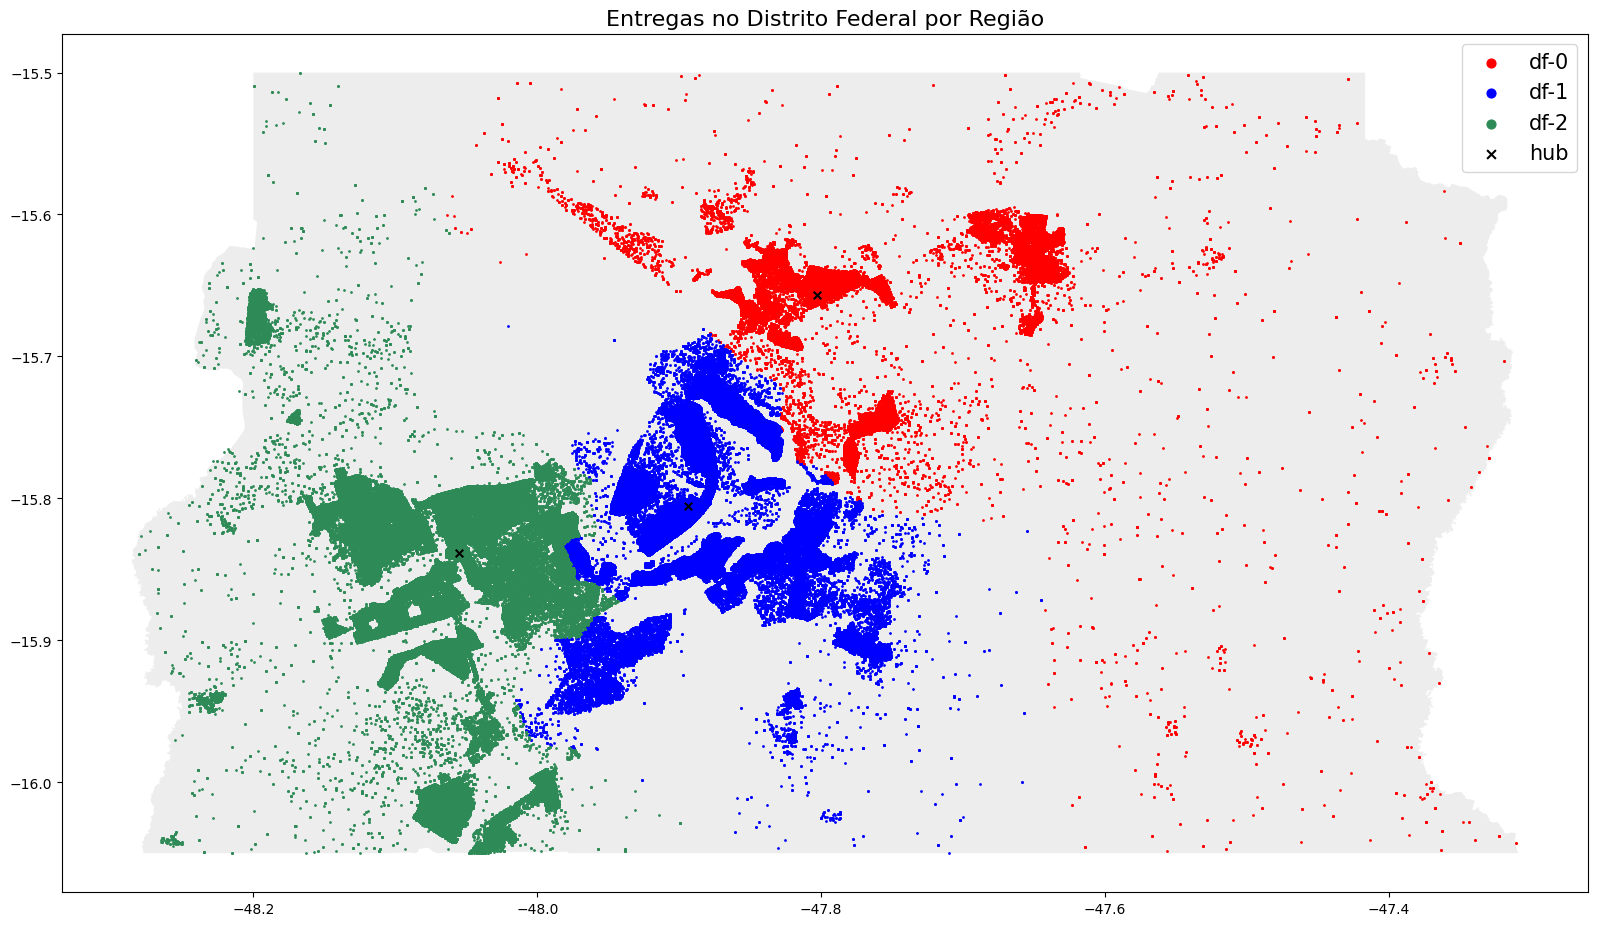

In [79]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color='red', label='df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color='blue', label='df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color='seagreen', label='df-2')

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

# plot da legenda
plt.title('Entregas no Distrito Federal por Região', fontdict={'fontsize': 16})
lgnd = plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([40])

**Insight 1:** Percebemos que os hubs df-2 e df-0 possuem entregas em locais distantes, o que pode gerar um aumento no tempo de entrega e nos preços dessas entregas. Além disso, podemos ver que as entregas estão corretamente alocadas aos seus respectivos hubs. 

In [84]:
#proporção de cada hub
proporcao = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
proporcao.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


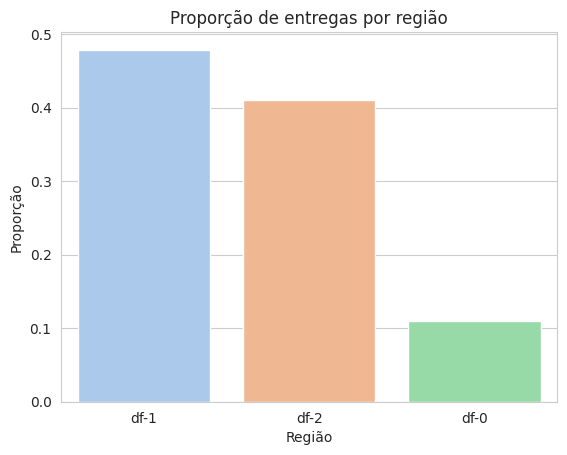

In [88]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=proporcao, x='region', y='proportion',hue='region', errorbar=None, palette='pastel', legend= False)
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')

**Insights 2:** Analisando a distribuição de entregas, podemos analisar que o hub df-0 está sendo mal aproveitando, já que a capacidade dos veículos é a mesma para todos os hubs como foi observado anteriormente.

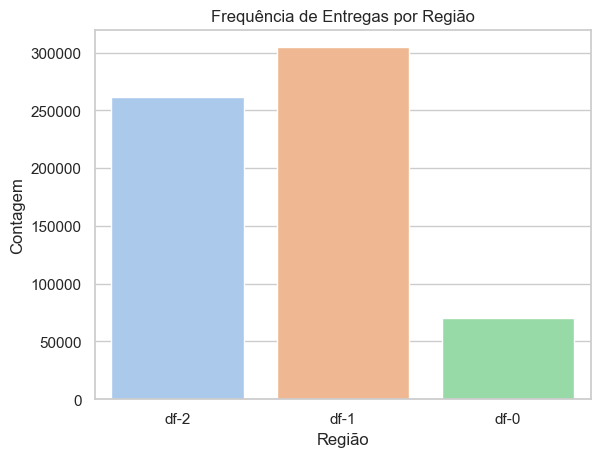

In [102]:
with sns.axes_style('whitegrid'):
    grafico = sns.countplot(data=geo_deliveries_df, x='region',hue= 'region', palette='pastel')
    grafico.set(title = 'Frequência de Entregas por Região',xlabel='Região',ylabel='Contagem')

c:\Users\Gabriel Canuto\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


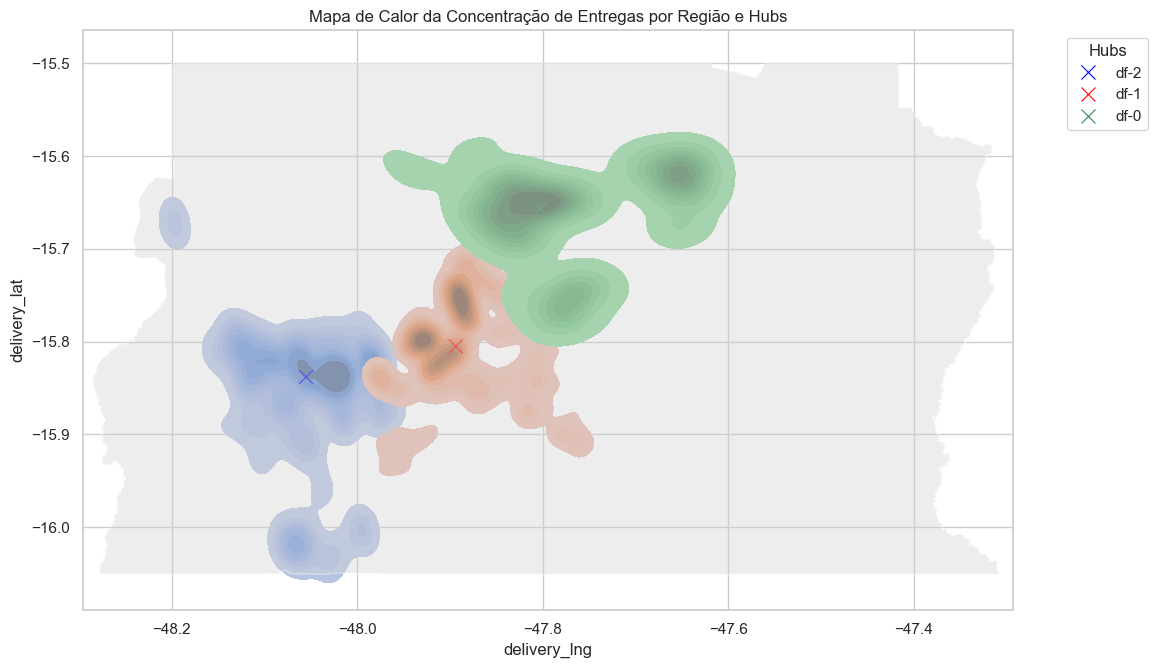

In [121]:
# Amostra representativa de 10% dos dados
sampled_geo_deliveries_df = geo_deliveries_df.sample(frac=0.1, random_state=42)
sns.set(style="whitegrid")
# Criação do gráfico de densidade (mapa de calor)
plt.figure(figsize=(12, 8))
plot = sns.kdeplot(data=sampled_geo_deliveries_df,x='delivery_lng',y='delivery_lat',hue='region',fill=True,cmap=sns.color_palette(['seagreen','blue','red']),common_norm=False)
# Adiciona os hubs ao gráfico com cores distintas
hubs_palette = {'df-0': 'seagreen','df-1': 'red','df-2': 'blue'}
sns.scatterplot(x='hub_lng', y='hub_lat', data=geo_hub_df, hue='region', palette=hubs_palette, marker='x', s=100, legend='full')
# Adiciona o mapa do Distrito Federal como fundo
mapa.plot(ax=plt.gca(), alpha=0.4, color="lightgrey")
# Ajusta a legenda para incluir hubs
hubs_legend_mapping = {'df-0': 'df-0', 'df-1': 'df-1', 'df-2': 'df-2'}
handles, labels = plot.get_legend_handles_labels()
for i, region in enumerate(labels):
    if region in hubs_legend_mapping:
        labels[i] = hubs_legend_mapping[region]
plt.legend(handles, labels, title='Hubs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Mapa de Calor da Concentração de Entregas por Região e Hubs')

plt.show()

**Insights 3:** O gráfico de calor acima mostra que os hubs 'df-2' e 'df-1' estão próximos as região com maior quantidade de entregas, porém o hub 'df-0' está um pouco afastado das regiões com maior frequência, representadas no gráfico pela tonalidade mais escura.